### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torchvision.utils import make_grid


In [181]:
torch.manual_seed(7)
np.random.seed(7)

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [183]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 16
config.noise_size = 50
config.print_freq = 100

config.lr = 1e-4
config.betas = (0.5,0.9)
config.n_disc = 5
config.clip_value = 0.01
config.grad_penalty = 10

config.img_shape = (1,28,28)
config.img_dim = 28*28

print(config.__dict__)

{'mnist_path': None, 'batch_size': 16, 'num_workers': 3, 'num_epochs': 16, 'noise_size': 50, 'print_freq': 100, 'lr': 0.0001, 'betas': (0.5, 0.9), 'n_disc': 5, 'clip_value': 0.01, 'grad_penalty': 10, 'img_shape': (1, 28, 28), 'img_dim': 784}


In [184]:
train = torchvision.datasets.FashionMNIST(
  root=(config.mnist_path or "fashion_mnist"),
  train=True,
  transform=torchvision.transforms.ToTensor(),
  download=True)

In [185]:
dataloader = DataLoader(
  dataset=train,
  batch_size=config.batch_size,
  shuffle=True,
  drop_last=True)

In [186]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [187]:
len(dataloader)

3750

In [188]:
for image, cat in dataloader:
    print("image:", image.shape, image.dtype, "min/max:", image.min().item(), image.max().item())
    print("cat:", cat.shape, cat.dtype, "labels:", cat[:10].tolist())
    break

image: torch.Size([16, 1, 28, 28]) torch.float32 min/max: 0.0 1.0
cat: torch.Size([16]) torch.int64 labels: [2, 9, 6, 3, 5, 2, 0, 1, 2, 4]


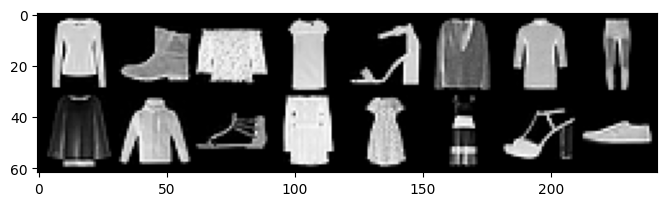

In [189]:
N = min(32, image.size(0))
grid = make_grid(image[:N], nrow=8, padding=2)

grid = grid.detach().permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.show()

### Задание 1

In [190]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
        
    def forward(self, x):
        return self.model(x)

In [191]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

В оригинальной статье для WGAN, в качестве оптимизатора авторы использовали RMSProp

In [192]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=config.lr)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=config.lr)

criterion = None

Введем loss.
Discriptor должен максимизировать E[D(real)] - E[D(fake)], значит при минимизации мы берём 
D_loss = E[D(fake)] - E[D(real)]. 

Generator хочет, чтобы фейки получали высокий score у Discriptor, значит G_loss = -E[D(fake)].

In [193]:
def wgan_disc_loss(d_real, d_fake):
    return d_fake.mean() - d_real.mean()

def wgan_gen_loss(d_fake):
    return -d_fake.mean()

In [194]:
input = torch.empty(config.batch_size, config.img_dim, device=device)

noise = torch.empty(config.batch_size, config.noise_size, device=device)

fixed_noise = torch.randn(config.batch_size, config.noise_size, device=device)

In [195]:
print(input.device, noise.device, fixed_noise.device)

cpu cpu cpu


In [196]:
with torch.no_grad():
    tmp = generator(torch.randn(2, config.noise_size, device=device))
print(tmp.shape)

torch.Size([2, 784])


Epoch [1/16] Step 0 | D_loss: -0.0045 | G_loss: -0.0039
Epoch [1/16] Step 1000 | D_loss: -0.0666 | G_loss: -0.0154
Epoch [1/16] Step 2000 | D_loss: -0.0713 | G_loss: -0.2225
Epoch [1/16] Step 3000 | D_loss: -0.0548 | G_loss: 0.0052


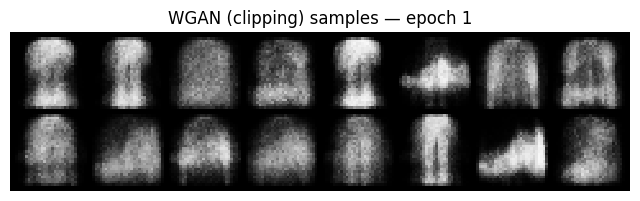

Epoch [2/16] Step 4000 | D_loss: -0.0625 | G_loss: -0.1605
Epoch [2/16] Step 5000 | D_loss: -0.0598 | G_loss: 0.0668
Epoch [2/16] Step 6000 | D_loss: -0.0348 | G_loss: -0.0705
Epoch [2/16] Step 7000 | D_loss: -0.0291 | G_loss: -0.0048
Epoch [3/16] Step 8000 | D_loss: -0.0332 | G_loss: -0.0842
Epoch [3/16] Step 9000 | D_loss: -0.0435 | G_loss: 0.0606
Epoch [3/16] Step 10000 | D_loss: -0.0332 | G_loss: -0.0583
Epoch [3/16] Step 11000 | D_loss: -0.0277 | G_loss: 0.0163


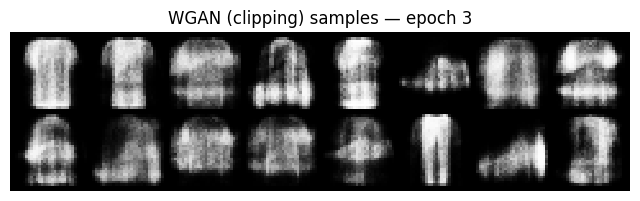

Epoch [4/16] Step 12000 | D_loss: -0.0231 | G_loss: -0.0430
Epoch [4/16] Step 13000 | D_loss: -0.0199 | G_loss: -0.0052
Epoch [4/16] Step 14000 | D_loss: -0.0245 | G_loss: -0.0197
Epoch [5/16] Step 15000 | D_loss: -0.0117 | G_loss: 0.0267
Epoch [5/16] Step 16000 | D_loss: -0.0351 | G_loss: -0.0428
Epoch [5/16] Step 17000 | D_loss: -0.0384 | G_loss: 0.1066
Epoch [5/16] Step 18000 | D_loss: -0.0079 | G_loss: -0.0705


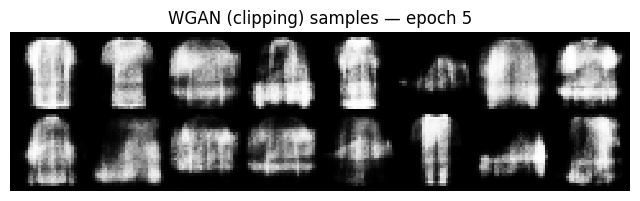

Epoch [6/16] Step 19000 | D_loss: -0.0234 | G_loss: 0.0833
Epoch [6/16] Step 20000 | D_loss: -0.0536 | G_loss: -0.1335
Epoch [6/16] Step 21000 | D_loss: -0.0152 | G_loss: 0.0034
Epoch [6/16] Step 22000 | D_loss: -0.0313 | G_loss: -0.0510
Epoch [7/16] Step 23000 | D_loss: -0.0227 | G_loss: -0.0521
Epoch [7/16] Step 24000 | D_loss: -0.0144 | G_loss: -0.0467
Epoch [7/16] Step 25000 | D_loss: 0.0148 | G_loss: -0.0996
Epoch [7/16] Step 26000 | D_loss: -0.0553 | G_loss: 0.0806


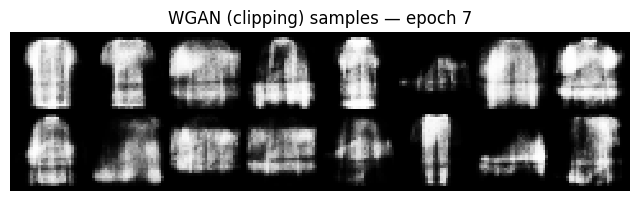

Epoch [8/16] Step 27000 | D_loss: -0.0054 | G_loss: 0.0973
Epoch [8/16] Step 28000 | D_loss: -0.0273 | G_loss: -0.0404
Epoch [8/16] Step 29000 | D_loss: -0.0238 | G_loss: 0.0957
Epoch [9/16] Step 30000 | D_loss: -0.0258 | G_loss: -0.1297
Epoch [9/16] Step 31000 | D_loss: 0.0000 | G_loss: -0.0234
Epoch [9/16] Step 32000 | D_loss: 0.0130 | G_loss: -0.0135
Epoch [9/16] Step 33000 | D_loss: -0.0274 | G_loss: 0.1154


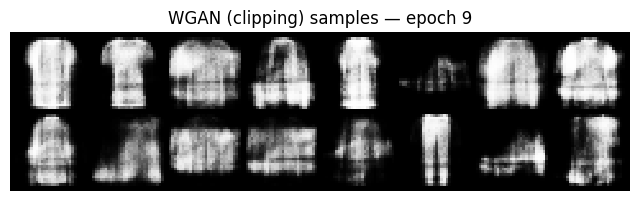

Epoch [10/16] Step 34000 | D_loss: -0.0274 | G_loss: -0.0071
Epoch [10/16] Step 35000 | D_loss: -0.0025 | G_loss: -0.0494
Epoch [10/16] Step 36000 | D_loss: -0.0312 | G_loss: 0.0889
Epoch [10/16] Step 37000 | D_loss: -0.0178 | G_loss: -0.0015
Epoch [11/16] Step 38000 | D_loss: -0.0166 | G_loss: 0.0578
Epoch [11/16] Step 39000 | D_loss: 0.0400 | G_loss: 0.0723
Epoch [11/16] Step 40000 | D_loss: 0.0177 | G_loss: 0.1417
Epoch [11/16] Step 41000 | D_loss: -0.0261 | G_loss: -0.1010


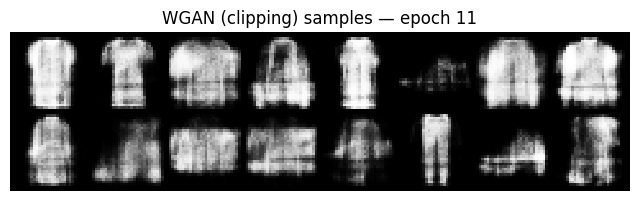

Epoch [12/16] Step 42000 | D_loss: -0.0024 | G_loss: -0.1663
Epoch [12/16] Step 43000 | D_loss: -0.0145 | G_loss: -0.0697
Epoch [12/16] Step 44000 | D_loss: 0.0063 | G_loss: -0.0522
Epoch [13/16] Step 45000 | D_loss: 0.0054 | G_loss: -0.0329
Epoch [13/16] Step 46000 | D_loss: 0.0074 | G_loss: -0.0546
Epoch [13/16] Step 47000 | D_loss: -0.0055 | G_loss: 0.0140
Epoch [13/16] Step 48000 | D_loss: -0.0138 | G_loss: -0.0669


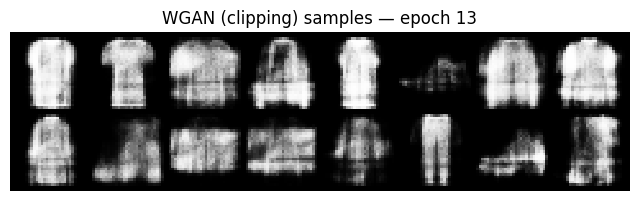

Epoch [14/16] Step 49000 | D_loss: 0.0056 | G_loss: 0.0035
Epoch [14/16] Step 50000 | D_loss: -0.0029 | G_loss: -0.0555
Epoch [14/16] Step 51000 | D_loss: 0.0011 | G_loss: -0.0478
Epoch [14/16] Step 52000 | D_loss: -0.0068 | G_loss: 0.0262
Epoch [15/16] Step 53000 | D_loss: -0.0007 | G_loss: -0.0131
Epoch [15/16] Step 54000 | D_loss: -0.0080 | G_loss: -0.0156
Epoch [15/16] Step 55000 | D_loss: 0.0093 | G_loss: 0.0729
Epoch [15/16] Step 56000 | D_loss: -0.0056 | G_loss: 0.0918


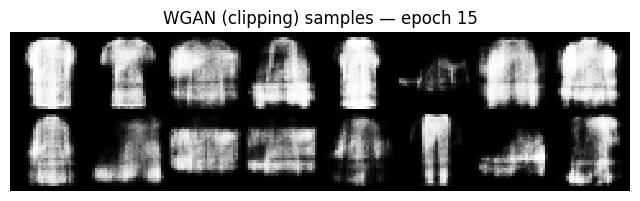

Epoch [16/16] Step 57000 | D_loss: -0.0050 | G_loss: -0.0488
Epoch [16/16] Step 58000 | D_loss: 0.0079 | G_loss: 0.0311
Epoch [16/16] Step 59000 | D_loss: -0.0229 | G_loss: 0.0437


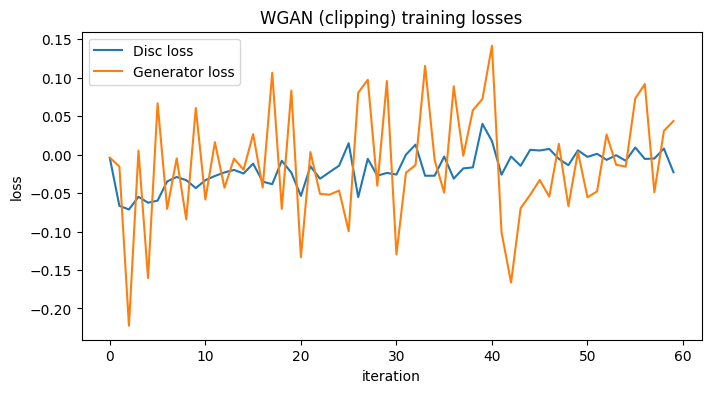

In [197]:
G_losses, D_losses = [], []
step = 0

generator.train()
discriminator.train()

for epoch in range(config.num_epochs):
    for i, (real, y) in enumerate(dataloader):
        # Discriminator
        real = real.to(device)
        B = real.size(0)

        if real.dim() == 4:
          real_flat = real.view(B, -1)
        else:
          real_flat = real
          
        discriminator.zero_grad()
        
        for _ in range(config.n_disc):
            z = torch.randn(B, config.noise_size, device=device)
            fake = generator(z).detach()

            if fake.dim() == 4:
                fake_flat = fake.view(B, -1)
            else:
                fake_flat = fake

            optim_D.zero_grad(set_to_none=True)
            d_real = discriminator(real_flat)
            d_fake = discriminator(fake_flat)
            d_loss = wgan_disc_loss(d_real, d_fake)
            d_loss.backward()
            optim_D.step()

            # Weight clipping (WGAN)
            clip = config.clip_value
            for p in discriminator.parameters():
                p.data.clamp_(-clip, clip)
        
        # Generator stage

        z = torch.randn(B, config.noise_size, device=device)
        optim_G.zero_grad(set_to_none=True)
        fake = generator(z)

        if fake.dim() == 4:
            fake_flat = fake.view(B, -1)
        else:
            fake_flat = fake

        d_fake = discriminator(fake_flat)
        g_loss = wgan_gen_loss(d_fake)
        g_loss.backward()
        optim_G.step()

        if step % 1000 == 0:
            print(f"Epoch [{epoch+1}/{config.num_epochs}] Step {step} | "
                  f"D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

        step += 1

    if epoch % 2 == 0:
      generator.eval()
      with torch.no_grad():
        fake_vis = generator(fixed_noise)
        if fake_vis.dim() == 2:
            fake_vis = fake_vis.view(fake_vis.size(0), 1, 28, 28)
        grid = make_grid(fake_vis[:32].detach().cpu(), nrow=8, padding=2)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).numpy(), interpolation="nearest")
        plt.axis("off")
        plt.title(f"WGAN (clipping) samples — epoch {epoch+1}")
        plt.show()
      generator.train()

plt.figure(figsize=(8,4))
plt.plot(D_losses, label="Disc loss")
plt.plot(G_losses, label="Generator loss")
plt.legend()
plt.title("WGAN (clipping) training losses")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

Задание 1: WGAN с weight clipping

- Изменил дискриминатор - убрал Sigmoid, BCE не использовал
- Реализовал лоссы WGAN: 
  - Disc:  E[D(fake)] - E[D(real)]
  - Generator: -E[D(fake)]
- Добавил n_disc = {config.n_disc} обновлений критика на 1 шаг генератора.
- Добавил weight clipping с clip_value = {config.clip_value}.

Архитектура:
- Generator: MLP (noise_size={config.noise_size}), выход в [0,1] (Sigmoid).
- Critic: MLP, без Sigmoid.

Выводы про сходимость GAN/WGAN:
- Weight clipping сильно ограничивает дискриминатор и может ухудшать стабильность при плохом clip_value.
- Для стабильности важны: n_disc>1 и подходяший lr

### Задание 2

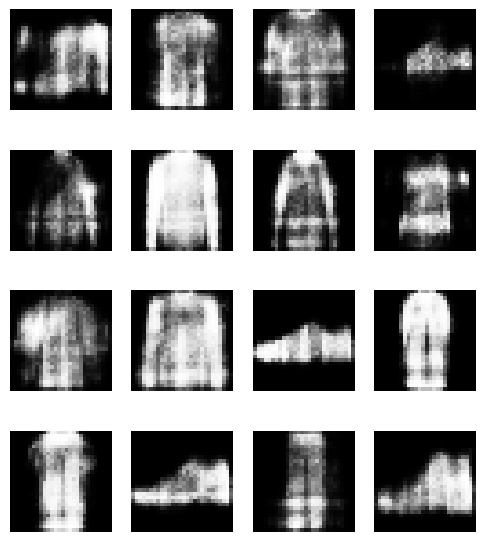

In [198]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [199]:
def gradient_penalty(disc, real_flat, fake_flat, device, lambda_gp=10.0):
    B = real_flat.size(0)
    eps = torch.rand(B, 1, device=device)
    x_hat = eps * real_flat + (1 - eps) * fake_flat
    x_hat.requires_grad_(True)

    d_hat = disc(x_hat)

    grads = torch_grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    grad_norm = grads.norm(2, dim=1)
    gp = lambda_gp * ((grad_norm - 1.0) ** 2).mean()
    return gp

In [200]:
optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=config.betas)
optim_D = optim.Adam(discriminator.parameters(), lr=config.lr, betas=config.betas)

Epoch [1/16] Step 0 | D_loss: 9.8195 | G_loss: 0.0754
Epoch [1/16] Step 1000 | D_loss: 3.8908 | G_loss: -0.3137
Epoch [1/16] Step 2000 | D_loss: 1.9257 | G_loss: -2.5204
Epoch [1/16] Step 3000 | D_loss: 0.2312 | G_loss: -0.9674


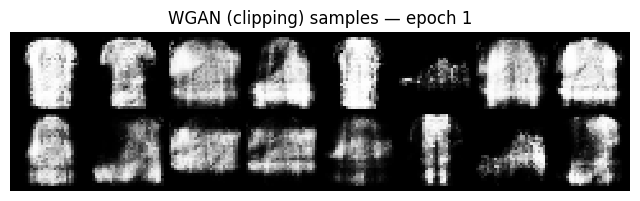

Epoch [2/16] Step 4000 | D_loss: 1.9358 | G_loss: -0.2990
Epoch [2/16] Step 5000 | D_loss: 0.7180 | G_loss: -0.0461
Epoch [2/16] Step 6000 | D_loss: -0.2350 | G_loss: -0.5378
Epoch [2/16] Step 7000 | D_loss: -0.7785 | G_loss: 0.0472
Epoch [3/16] Step 8000 | D_loss: -0.7410 | G_loss: -0.2746
Epoch [3/16] Step 9000 | D_loss: -1.0130 | G_loss: 0.2697
Epoch [3/16] Step 10000 | D_loss: -1.2525 | G_loss: 2.6315
Epoch [3/16] Step 11000 | D_loss: -1.2387 | G_loss: -0.1769


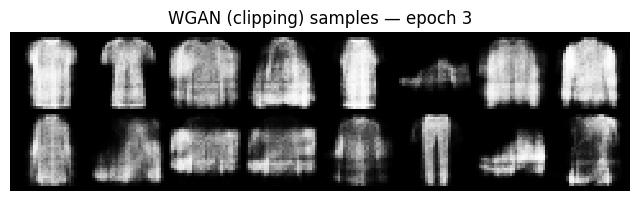

Epoch [4/16] Step 12000 | D_loss: -0.9906 | G_loss: 0.3131
Epoch [4/16] Step 13000 | D_loss: -0.8439 | G_loss: -0.7740
Epoch [4/16] Step 14000 | D_loss: -1.1956 | G_loss: -1.0597
Epoch [5/16] Step 15000 | D_loss: -0.8109 | G_loss: -1.2855
Epoch [5/16] Step 16000 | D_loss: -1.1345 | G_loss: -0.7821
Epoch [5/16] Step 17000 | D_loss: -0.6023 | G_loss: 0.4731
Epoch [5/16] Step 18000 | D_loss: -0.6082 | G_loss: -0.8347


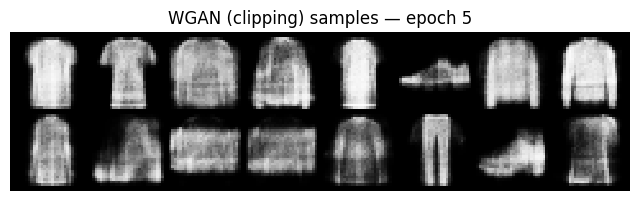

Epoch [6/16] Step 19000 | D_loss: -1.0566 | G_loss: -1.9101
Epoch [6/16] Step 20000 | D_loss: -0.7858 | G_loss: -0.2924
Epoch [6/16] Step 21000 | D_loss: -1.0103 | G_loss: -1.9966
Epoch [6/16] Step 22000 | D_loss: -1.2322 | G_loss: -2.0329
Epoch [7/16] Step 23000 | D_loss: -0.6615 | G_loss: -2.3925
Epoch [7/16] Step 24000 | D_loss: -0.8103 | G_loss: -1.3268
Epoch [7/16] Step 25000 | D_loss: -0.7350 | G_loss: -2.6894
Epoch [7/16] Step 26000 | D_loss: -0.8764 | G_loss: -2.7730


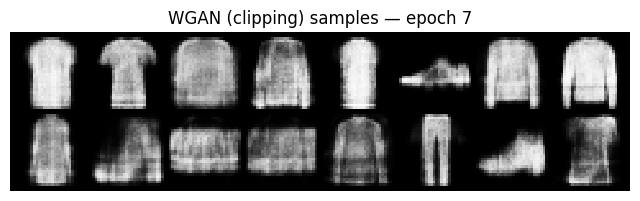

Epoch [8/16] Step 27000 | D_loss: -0.8531 | G_loss: -1.5716
Epoch [8/16] Step 28000 | D_loss: -1.0640 | G_loss: -1.8022
Epoch [8/16] Step 29000 | D_loss: -0.1478 | G_loss: -3.4756
Epoch [9/16] Step 30000 | D_loss: -0.7786 | G_loss: -2.3036
Epoch [9/16] Step 31000 | D_loss: -0.9339 | G_loss: -3.3944
Epoch [9/16] Step 32000 | D_loss: -1.7551 | G_loss: -3.0339
Epoch [9/16] Step 33000 | D_loss: -0.3964 | G_loss: -3.3621


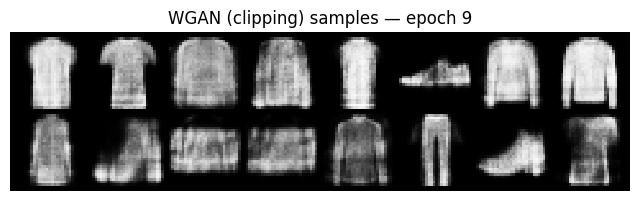

Epoch [10/16] Step 34000 | D_loss: -0.2638 | G_loss: -2.4513
Epoch [10/16] Step 35000 | D_loss: -0.7542 | G_loss: -1.6574
Epoch [10/16] Step 36000 | D_loss: -1.0078 | G_loss: -3.7394
Epoch [10/16] Step 37000 | D_loss: -0.9654 | G_loss: -1.1295
Epoch [11/16] Step 38000 | D_loss: -1.3438 | G_loss: -2.2054
Epoch [11/16] Step 39000 | D_loss: -0.9871 | G_loss: -1.4485
Epoch [11/16] Step 40000 | D_loss: -1.3437 | G_loss: -2.9733
Epoch [11/16] Step 41000 | D_loss: -0.8052 | G_loss: -2.7925


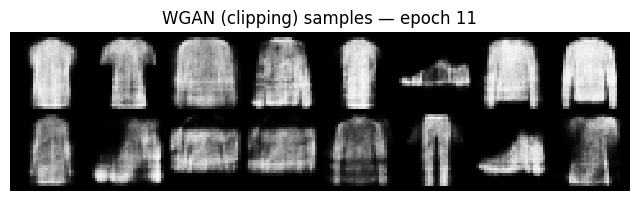

Epoch [12/16] Step 42000 | D_loss: -0.0678 | G_loss: -3.0941
Epoch [12/16] Step 43000 | D_loss: -0.7272 | G_loss: -3.3001
Epoch [12/16] Step 44000 | D_loss: -0.6818 | G_loss: -2.0821
Epoch [13/16] Step 45000 | D_loss: -0.8370 | G_loss: -2.5449
Epoch [13/16] Step 46000 | D_loss: -0.5080 | G_loss: -3.0273
Epoch [13/16] Step 47000 | D_loss: -0.5829 | G_loss: -2.5031
Epoch [13/16] Step 48000 | D_loss: -0.1471 | G_loss: -1.8981


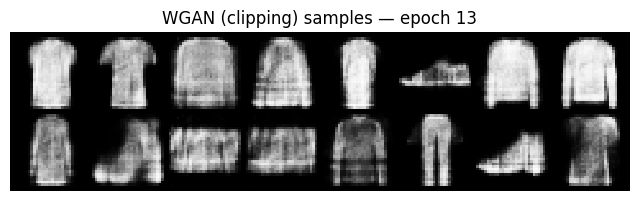

Epoch [14/16] Step 49000 | D_loss: -0.0256 | G_loss: -2.5484
Epoch [14/16] Step 50000 | D_loss: -0.2315 | G_loss: -2.2486
Epoch [14/16] Step 51000 | D_loss: -0.5419 | G_loss: -1.5549
Epoch [14/16] Step 52000 | D_loss: -0.3910 | G_loss: -2.3303
Epoch [15/16] Step 53000 | D_loss: -0.3336 | G_loss: -1.6511
Epoch [15/16] Step 54000 | D_loss: -0.6243 | G_loss: -1.7058
Epoch [15/16] Step 55000 | D_loss: -0.4841 | G_loss: -1.3941
Epoch [15/16] Step 56000 | D_loss: -0.2136 | G_loss: -2.1813


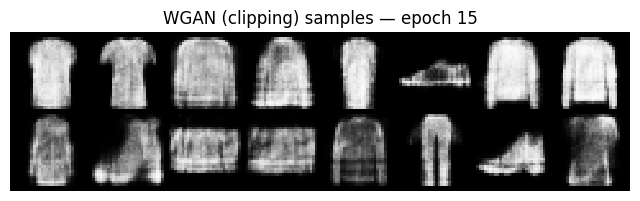

Epoch [16/16] Step 57000 | D_loss: -1.0041 | G_loss: 0.0229
Epoch [16/16] Step 58000 | D_loss: -0.3489 | G_loss: -2.0329
Epoch [16/16] Step 59000 | D_loss: -0.7466 | G_loss: -1.6933


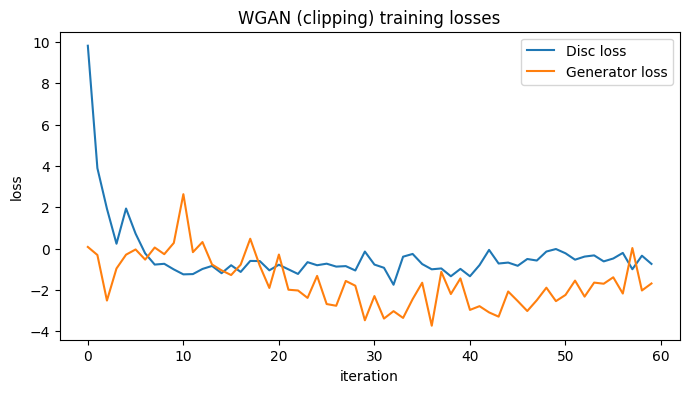

In [201]:
G_losses, D_losses = [], []
step = 0

generator.train()
discriminator.train()

for epoch in range(config.num_epochs):
    for i, (real, y) in enumerate(dataloader):
        # Discriminator
        real = real.to(device)
        B = real.size(0)

        if real.dim() == 4:
            real_flat = real.view(B, -1)
        else:
            real_flat = real

        discriminator.zero_grad()

        for _ in range(config.n_disc):
            z = torch.randn(B, config.noise_size, device=device)
            fake = generator(z).detach()

            if fake.dim() == 4:
                fake_flat = fake.view(B, -1)
            else:
                fake_flat = fake

            optim_D.zero_grad(set_to_none=True)
            d_real = discriminator(real_flat)
            d_fake = discriminator(fake_flat)

            gp = gradient_penalty(
                disc=discriminator,
                real_flat=real_flat,
                fake_flat=fake_flat,
                device=device,
                lambda_gp=config.grad_penalty,
            )

            d_loss = wgan_disc_loss(d_real, d_fake) + gp
            d_loss.backward()
            optim_D.step()

        # Generator stage

        z = torch.randn(B, config.noise_size, device=device)
        optim_G.zero_grad(set_to_none=True)
        fake = generator(z)

        if fake.dim() == 4:
            fake_flat = fake.view(B, -1)
        else:
            fake_flat = fake

        d_fake = discriminator(fake_flat)
        g_loss = wgan_gen_loss(d_fake)
        g_loss.backward()
        optim_G.step()

        if step % 1000 == 0:
            print(
                f"Epoch [{epoch+1}/{config.num_epochs}] Step {step} | "
                f"D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}"
            )
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

        step += 1

    if epoch % 2 == 0:
        generator.eval()
        with torch.no_grad():
            fake_vis = generator(fixed_noise)
            if fake_vis.dim() == 2:
                fake_vis = fake_vis.view(fake_vis.size(0), 1, 28, 28)
            grid = make_grid(fake_vis[:32].detach().cpu(), nrow=8, padding=2)
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).numpy(), interpolation="nearest")
            plt.axis("off")
            plt.title(f"WGAN (clipping) samples — epoch {epoch+1}")
            plt.show()
        generator.train()

plt.figure(figsize=(8, 4))
plt.plot(D_losses, label="Disc loss")
plt.plot(G_losses, label="Generator loss")
plt.legend()
plt.title("WGAN (clipping) training losses")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

Задание 2: WGAN-GP

- Полностью убрал weight clipping.
- Добавил gradient penalty:
- Discriptor loss: E[D(fake)] − E[D(real)] + GP. Generator loss: −E[D(fake)].

Архитектура:
- Generator: MLP (noise_size={config.noise_size}), выход в [0,1] (Sigmoid).
- Critic: MLP, без Sigmoid.

Выводы про сходимость:
- WGAN-GP стабильнее clipping, потому что Lipschitz условие задаётся через градиенты по входу, а не через обрезку весов

### Задание 3

In [202]:
print(generator(torch.randn(2, config.noise_size, device=device)).shape)

torch.Size([2, 784])


In [203]:
config.n_classes = 10

In [204]:
def one_hot(y, n_classes, device):
    return F.one_hot(y, num_classes=n_classes).float().to(device)

Модифицируем генератор и дискриптор

In [205]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + config.n_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z, y_onehot):
        inp = torch.cat([z, y_onehot], dim=1)
        return self.model(inp)

In [206]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + config.n_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1) 
        )

    def forward(self, x_flat, y_onehot):
        inp = torch.cat([x_flat, y_onehot], dim=1)
        return self.model(inp)

In [207]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=config.betas)
optim_D = optim.Adam(discriminator.parameters(), lr=config.lr, betas=config.betas)

In [208]:
def gradient_penalty_cond(disc, real_flat, fake_flat, y_onehot, device, lambda_gp=10.0):
    B = real_flat.size(0)
    eps = torch.rand(B, 1, device=device)
    x_hat = eps * real_flat + (1 - eps) * fake_flat
    x_hat.requires_grad_(True)

    d_hat = disc(x_hat, y_onehot)

    grads = torch_grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=torch.ones_like(d_hat),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grads = grads.view(B, -1)
    gp = lambda_gp * ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

Epoch [1/16] Step 0 | D_loss: 7.9334 | G_loss: 0.1596
Epoch [1/16] Step 1000 | D_loss: -4.6704 | G_loss: -1.6706
Epoch [1/16] Step 2000 | D_loss: -5.1029 | G_loss: -2.4145
Epoch [1/16] Step 3000 | D_loss: -3.6804 | G_loss: -2.9290


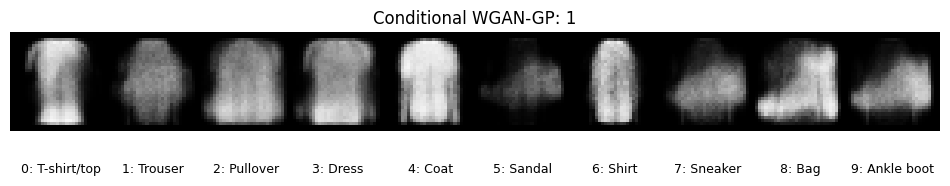

Epoch [2/16] Step 4000 | D_loss: -3.4255 | G_loss: -5.0044
Epoch [2/16] Step 5000 | D_loss: -2.6121 | G_loss: -3.1454
Epoch [2/16] Step 6000 | D_loss: -2.3812 | G_loss: -2.3925
Epoch [2/16] Step 7000 | D_loss: -2.1303 | G_loss: -4.6542


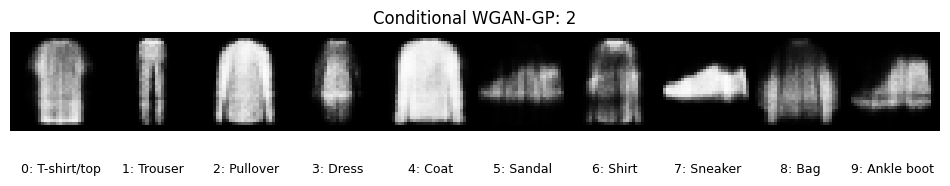

Epoch [3/16] Step 8000 | D_loss: -1.9234 | G_loss: -2.9565
Epoch [3/16] Step 9000 | D_loss: -2.0476 | G_loss: -2.0316
Epoch [3/16] Step 10000 | D_loss: -2.2226 | G_loss: -1.2355
Epoch [3/16] Step 11000 | D_loss: -1.8123 | G_loss: -1.2318


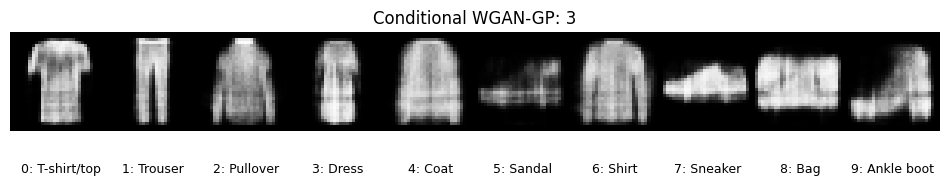

Epoch [4/16] Step 12000 | D_loss: -1.8151 | G_loss: -1.1996
Epoch [4/16] Step 13000 | D_loss: -1.8038 | G_loss: -0.1745
Epoch [4/16] Step 14000 | D_loss: -1.5216 | G_loss: -0.7984


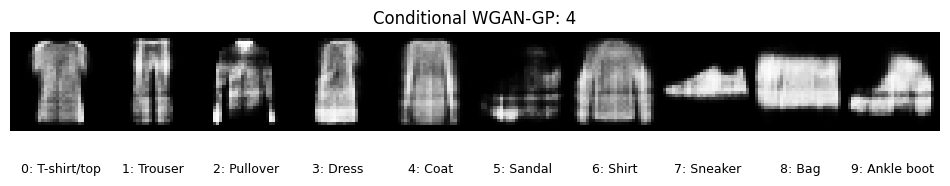

Epoch [5/16] Step 15000 | D_loss: -1.7233 | G_loss: -2.2943
Epoch [5/16] Step 16000 | D_loss: -1.6463 | G_loss: -3.2163
Epoch [5/16] Step 17000 | D_loss: -1.3229 | G_loss: 1.6872
Epoch [5/16] Step 18000 | D_loss: -0.5874 | G_loss: -1.5169


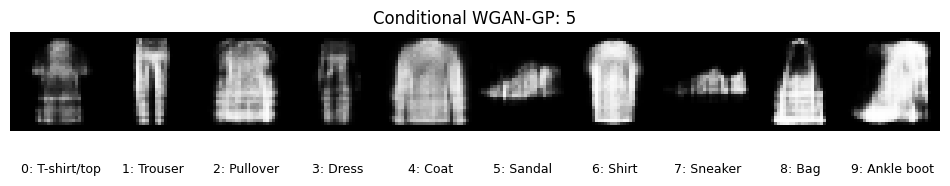

Epoch [6/16] Step 19000 | D_loss: -1.7539 | G_loss: 0.0468
Epoch [6/16] Step 20000 | D_loss: -1.4495 | G_loss: 0.5370
Epoch [6/16] Step 21000 | D_loss: -1.4192 | G_loss: -0.7350
Epoch [6/16] Step 22000 | D_loss: -1.3365 | G_loss: 0.5107


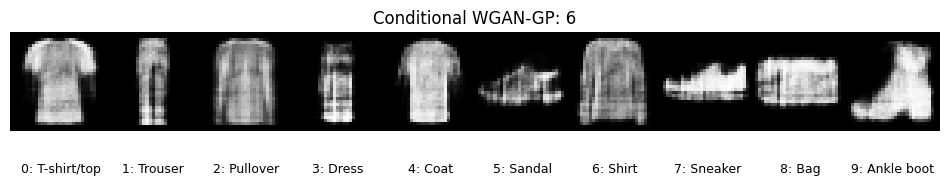

Epoch [7/16] Step 23000 | D_loss: -1.5592 | G_loss: -1.0233
Epoch [7/16] Step 24000 | D_loss: -1.0626 | G_loss: -0.2213
Epoch [7/16] Step 25000 | D_loss: -1.2765 | G_loss: 0.6355
Epoch [7/16] Step 26000 | D_loss: -0.9311 | G_loss: 1.1828


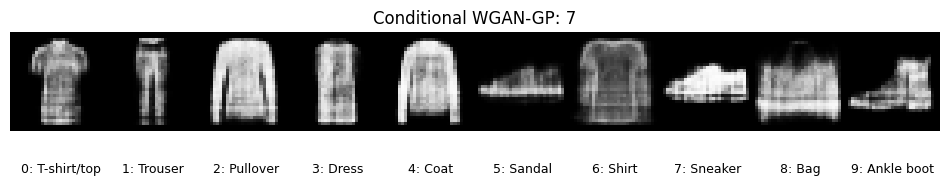

Epoch [8/16] Step 27000 | D_loss: -1.3518 | G_loss: 1.5754
Epoch [8/16] Step 28000 | D_loss: -0.8163 | G_loss: 1.8695
Epoch [8/16] Step 29000 | D_loss: -0.9510 | G_loss: 0.2392


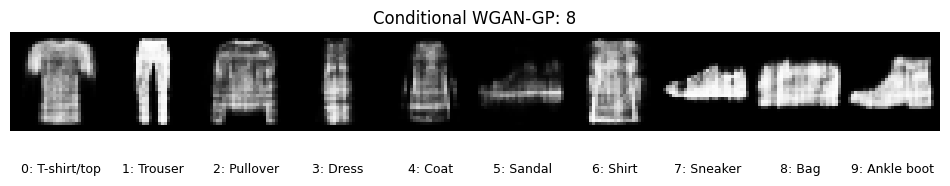

Epoch [9/16] Step 30000 | D_loss: -1.5987 | G_loss: -0.3415
Epoch [9/16] Step 31000 | D_loss: -0.9710 | G_loss: 1.3798
Epoch [9/16] Step 32000 | D_loss: -0.8738 | G_loss: 0.7233
Epoch [9/16] Step 33000 | D_loss: -0.8166 | G_loss: 1.0711


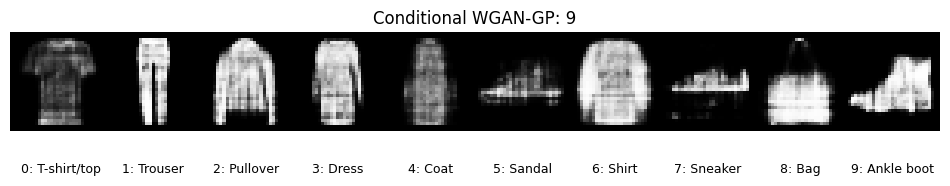

Epoch [10/16] Step 34000 | D_loss: -1.0982 | G_loss: 3.1161
Epoch [10/16] Step 35000 | D_loss: -1.2019 | G_loss: 2.1576
Epoch [10/16] Step 36000 | D_loss: -0.9023 | G_loss: 1.2198
Epoch [10/16] Step 37000 | D_loss: -1.2285 | G_loss: 2.2004


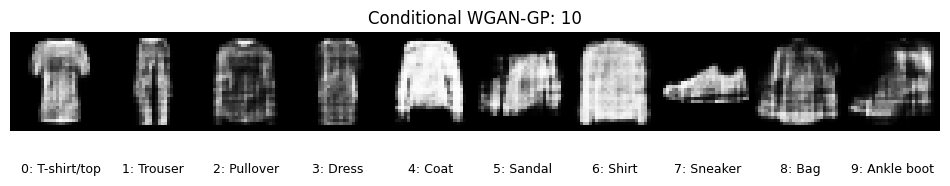

Epoch [11/16] Step 38000 | D_loss: -0.8667 | G_loss: 1.0544
Epoch [11/16] Step 39000 | D_loss: -0.7000 | G_loss: 0.1558
Epoch [11/16] Step 40000 | D_loss: -0.7081 | G_loss: 1.4428
Epoch [11/16] Step 41000 | D_loss: -1.0085 | G_loss: 3.9893


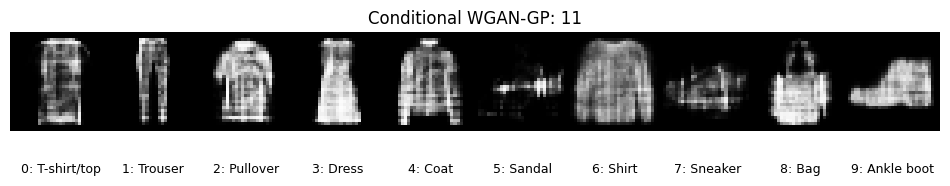

Epoch [12/16] Step 42000 | D_loss: -1.3608 | G_loss: 0.3143
Epoch [12/16] Step 43000 | D_loss: -0.8716 | G_loss: 0.9887
Epoch [12/16] Step 44000 | D_loss: -0.8403 | G_loss: 1.6139


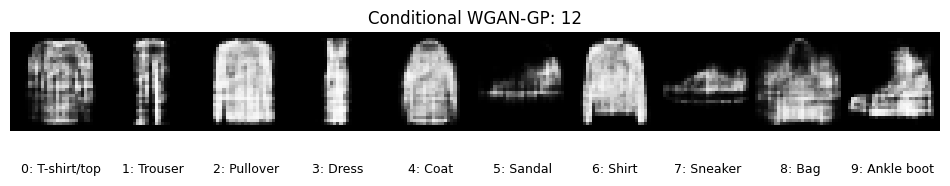

Epoch [13/16] Step 45000 | D_loss: -0.2047 | G_loss: -0.2664
Epoch [13/16] Step 46000 | D_loss: -0.8939 | G_loss: 1.4492
Epoch [13/16] Step 47000 | D_loss: -1.6824 | G_loss: -1.8143
Epoch [13/16] Step 48000 | D_loss: -0.9647 | G_loss: -0.8761


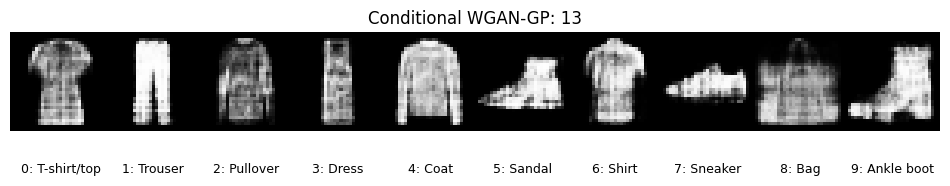

Epoch [14/16] Step 49000 | D_loss: -1.1545 | G_loss: 0.1507
Epoch [14/16] Step 50000 | D_loss: -0.8938 | G_loss: -0.0253
Epoch [14/16] Step 51000 | D_loss: -0.7318 | G_loss: 0.6949
Epoch [14/16] Step 52000 | D_loss: -0.8182 | G_loss: -0.2117


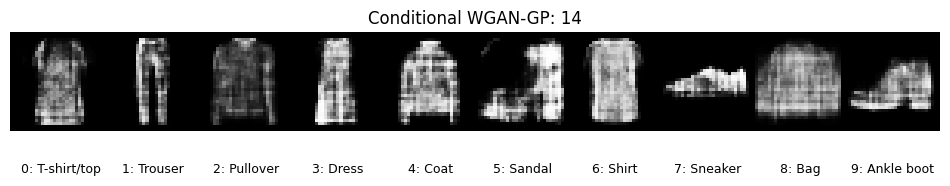

Epoch [15/16] Step 53000 | D_loss: -0.7276 | G_loss: 1.0622
Epoch [15/16] Step 54000 | D_loss: -1.0408 | G_loss: -0.5608
Epoch [15/16] Step 55000 | D_loss: -0.3756 | G_loss: 0.1504
Epoch [15/16] Step 56000 | D_loss: -0.7153 | G_loss: -0.1532


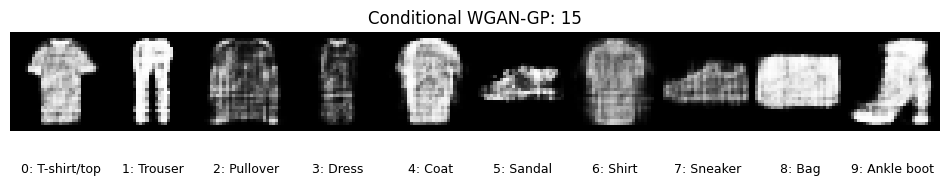

Epoch [16/16] Step 57000 | D_loss: -0.9728 | G_loss: 1.5295
Epoch [16/16] Step 58000 | D_loss: -0.5157 | G_loss: 1.5971
Epoch [16/16] Step 59000 | D_loss: -1.1182 | G_loss: 1.9146


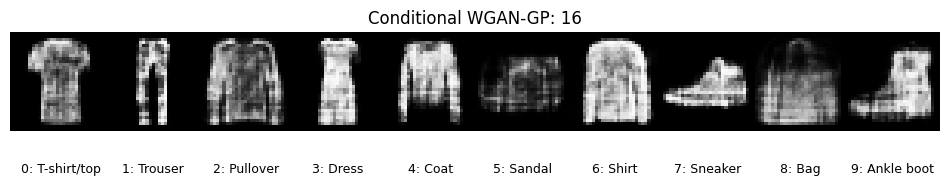

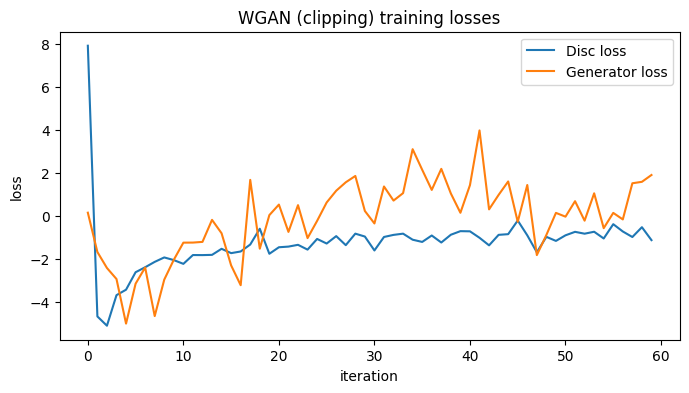

In [209]:
G_losses, D_losses = [], []
step = 0

generator.train()
discriminator.train()

for epoch in range(config.num_epochs):
    for i, (real, y) in enumerate(dataloader):
        # Discriminator
        real = real.to(device)
        B = real.size(0)

        y_oh = one_hot(y, config.n_classes, device)

        if real.dim() == 4:
            real_flat = real.view(B, -1)
        else:
            real_flat = real

        discriminator.zero_grad()

        for _ in range(config.n_disc):
            z = torch.randn(B, config.noise_size, device=device)
            fake = generator(z, y_oh).detach()

            if fake.dim() == 4:
                fake_flat = fake.view(B, -1)
            else:
                fake_flat = fake

            optim_D.zero_grad(set_to_none=True)

            d_real = discriminator(real_flat, y_oh)
            d_fake = discriminator(fake_flat, y_oh)

            gp = gradient_penalty_cond(
                disc=discriminator,
                real_flat=real_flat,
                fake_flat=fake_flat,
                y_onehot=y_oh,
                device=device,
                lambda_gp=getattr(config, "lambda_gp", 10.0),
            )

            d_loss = wgan_disc_loss(d_real, d_fake) + gp
            d_loss.backward()
            optim_D.step()

        # Generator stage

        z = torch.randn(B, config.noise_size, device=device)
        optim_G.zero_grad(set_to_none=True)
        fake = generator(z, y_oh)

        if fake.dim() == 4:
            fake_flat = fake.view(B, -1)
        else:
            fake_flat = fake

        d_fake = discriminator(fake_flat, y_oh)
        g_loss = wgan_gen_loss(d_fake)
        g_loss.backward()
        optim_G.step()

        if step % 1000 == 0:
            print(
                f"Epoch [{epoch+1}/{config.num_epochs}] Step {step} | "
                f"D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}"
            )
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

        step += 1

    generator.eval()
    with torch.no_grad():

        z = torch.randn(10, config.noise_size, device=device)
        y_demo = torch.arange(0, 10, device=device)
        y_demo_oh = one_hot(y_demo, config.n_classes, device)

        fake_demo = generator(z, y_demo_oh)
        if fake_demo.dim() == 2:
            fake_demo = fake_demo.view(10, 1, 28, 28)

        grid = make_grid(fake_demo.detach().cpu(), nrow=10, padding=2)
        plt.figure(figsize=(12, 2))
        plt.imshow(grid.permute(1, 2, 0).numpy(), interpolation="nearest")

        # названия классов FashionMNIST по индексам 0..9
        class_names = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ]

        ax = plt.gca()

        # вычисляем геометрию grid, чтобы знать центры колонок
        # grid имеет форму (C, H, W) до permute, после permute -> (H, W, C)
        H, W, _ = grid.permute(1, 2, 0).shape

        ncol = 10
        pad = 2  # ты передал padding=2 в make_grid
        cell_w = (W - pad * (ncol + 1)) / ncol  # ширина одной картинки

        # подписи под каждой колонкой (по центру)
        for j in range(ncol):
            x_center = pad + j * (cell_w + pad) + cell_w / 2
            # y чуть ниже изображения (можно подстроить)
            ax.text(
                x_center,
                H + 10,
                f"{j}: {class_names[j]}",
                ha="center",
                va="top",
                fontsize=9,
                color="black",
                clip_on=False,
            )
        
        plt.subplots_adjust(bottom=0.25)
        
        plt.axis("off")
        plt.title(f"Conditional WGAN-GP: {epoch+1}")
        plt.show()
        
        generator.train()

plt.figure(figsize=(8, 4))
plt.plot(D_losses, label="Disc loss")
plt.plot(G_losses, label="Generator loss")
plt.legend()
plt.title("WGAN (clipping) training losses")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

Задание 3: Conditional WGAN(-GP)

- Добавил условие на класс y (one-hot, 10 классов).
- Generator: вход = [z; one_hot(y)], Disc: вход = [x_flat; one_hot(y)].
- Обучение как WGAN-GP: Disc loss = E[D(fake,y)] − E[D(real,y)] + GP, Generator loss = −E[D(fake,y)].

Архитектура:
- G: MLP (noise_size + 10), Sigmoid.
- Critic: MLP (784 + 10), без Sigmoid.

Выводы:
- Условие помогает структурировать пространство генерации, но требует сильного дискриптора;
- Стабильность дают: n_disc>1, GP вместо clipping, адекватный lr и отсутствие BCE/sigmoid в disc.